
Project 2: Data Cleaning and Preparation

In [5]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline
sns.set(style='whitegrid')

# Global config
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import os
print(os.listdir())


['.config', 'cleaned_stock_data.csv', 'historical_stock_prices.csv', 'historical_stocks.csv', 'sample_data']


In [6]:
# Task 1 : Advanced Data Cleaning


# Load the datasets
df = pd.read_csv('historical_stock_prices.csv')
df_info = pd.read_csv('historical_stocks.csv')

print("📄 Stock Prices Data:")
print(df.head())

print("\n📄 Stock Info Data:")
print(df_info.head())

#  Handle Missing Values
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop any rows where the date conversion failed
df.dropna(subset=['date'], inplace=True)

# Merge datasets on 'ticker' to include sector info
df = pd.merge(df, df_info, on='ticker', how='left')

# Set 'date' as index for time series analysis
df.set_index('date', inplace=True)

print("\n✅ Merged and Indexed DataFrame Info:")
print(df.info())

# Display the first few rows of the final DataFrame
print("\n🔍 Preview of Cleaned and Merged Data:")
print(df.head())


📄 Stock Prices Data:
  ticker  open  close  adj_close   low  high   volume        date
0    AHH 11.50  11.58       8.49 11.25 11.68  4633900  2013-05-08
1    AHH 11.66  11.55       8.47 11.50 11.66   275800  2013-05-09
2    AHH 11.55  11.60       8.51 11.50 11.60   277100  2013-05-10
3    AHH 11.63  11.65       8.54 11.55 11.65   147400  2013-05-13
4    AHH 11.60  11.53       8.46 11.50 11.60   184100  2013-05-14

📄 Stock Info Data:
  ticker exchange                                    name             sector  \
0    PIH   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
1  PIHPP   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
2   TURN   NASDAQ                180 DEGREE CAPITAL CORP.            FINANCE   
3   FLWS   NASDAQ                 1-800 FLOWERS.COM, INC.  CONSUMER SERVICES   
4   FCCY   NASDAQ           1ST CONSTITUTION BANCORP (NJ)            FINANCE   

                     industry  
0  PROPERTY-CASUALTY INSURERS  
1  PROPERTY-CASUAL

In [4]:
#  Detect and Handle Outliers
#  Create a 'decade' column
df['decade'] = (df.index.year // 10) * 10

#  Group by 'decade' and 'sector' for future analysis
decades = df.groupby(['decade', 'sector'])

# Detect outliers in 'close' using IQR method
Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# ✅ Preview Cleaned Data
# -----------------------
print("✅ Cleaned Data Sample:")
display(df.head())
print("\n✅ Dataset shape:", df.shape)


✅ Cleaned Data Sample:


,ticker,open,close,adj_close,low,high,volume,exchange,name,sector,industry,decade
date,,,,,,,,,,,,
2013-05-08,AHH,11.50,11.58,8.49,11.25,11.68,4633900,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE,2010
2013-05-09,AHH,11.66,11.55,8.47,11.50,11.66,275800,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE,2010
2013-05-10,AHH,11.55,11.60,8.51,11.50,11.60,277100,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE,2010
2013-05-13,AHH,11.63,11.65,8.54,11.55,11.65,147400,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE,2010
2013-05-14,AHH,11.60,11.53,8.46,11.50,11.60,184100,NYSE,"ARMADA HOFFLER PROPERTIES, INC.",FINANCE,REAL ESTATE,2010



✅ Dataset shape: (20973889, 12)


In [5]:
# Task 2 : Data Transformation

# Feature Engineering

# Option A: Remove outliers (not required if capping is used)
# df = df[(df['close'] >= lower_bound) & (df['close'] <= upper_bound)]

# Option B: Cap outliers instead of removing them
df['close'] = np.where(df['close'] < lower_bound, lower_bound, df['close'])
df['close'] = np.where(df['close'] > upper_bound, upper_bound, df['close'])

# 5Correct logical errors — avoid negative prices
df['close'] = df['close'].apply(lambda x: abs(x) if x < 0 else x)

# Error Corrections

#  Remove duplicate rows
df.drop_duplicates(inplace=True)

# Calculate volatility (30-day rolling standard deviation)
df['volatility'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=30).std())

# Calculate Relative Strength Index (RSI)
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Rolling averages
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Avoid division by zero
rs = avg_gain / (avg_loss + 1e-10)
df['RSI'] = 100 - (100 / (1 + rs))

print(df[['close', 'volatility', 'RSI']].head())

            close  volatility  RSI
date                              
2013-05-08  11.58         NaN  NaN
2013-05-09  11.55         NaN  NaN
2013-05-10  11.60         NaN  NaN
2013-05-13  11.65         NaN  NaN
2013-05-14  11.53         NaN  NaN


In [12]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Check for required numeric columns
required_cols = {'close', 'volume'}
if required_cols.issubset(df.columns):
    df[['close', 'volume']] = scaler.fit_transform(df[['close', 'volume']])
    print("✅ Standardized 'close' and 'volume'.")
else:
    raise KeyError("❌ Required columns 'close' and/or 'volume' not found.")


✅ Standardized 'close' and 'volume'.


In [13]:

#  Encoding Categorical Variables
# One-hot encode 'sector' column
if 'sector' in df.columns:
    df = pd.get_dummies(df, columns=['sector'], drop_first=True)
    print("✅ One-hot encoding completed.")
else:
    print("ℹ️ 'sector' column not found. Skipping encoding.")



ℹ️ 'sector' column not found. Skipping encoding.


In [14]:
# Split into Train, Validation, and Test Sets

from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
if 'close' not in df.columns:
    raise KeyError("❌ Column 'close' not found for prediction target.")

X = df.drop('close', axis=1)
y = df['close']

# First: 80% train_val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second: 75% of train_val is train → 60% total, 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# Output split shapes
print("✅ Data successfully split:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


✅ Data successfully split:
X_train: (12584333, 20) y_train: (12584333,)
X_val: (4194778, 20) y_val: (4194778,)
X_test: (4194778, 20) y_test: (4194778,)


In [15]:
# Save cleaned and split datasets

df.to_csv('cleaned_transformed_data.csv', index=False)

# Save splits
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("✅ All data splits saved successfully.")


✅ All data splits saved successfully.


In [ ]:
#  Snapshot Comparison Before & After Cleaning

import pandas as pd

# 🔁 Change the file names if you named them differently
prices = pd.read_csv('historical_stock_prices.csv')      # Original data
merged_data = pd.read_csv('cleaned_stock_prices.csv')    # Cleaned data


/tmp/ipython-input-5-3245790413.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


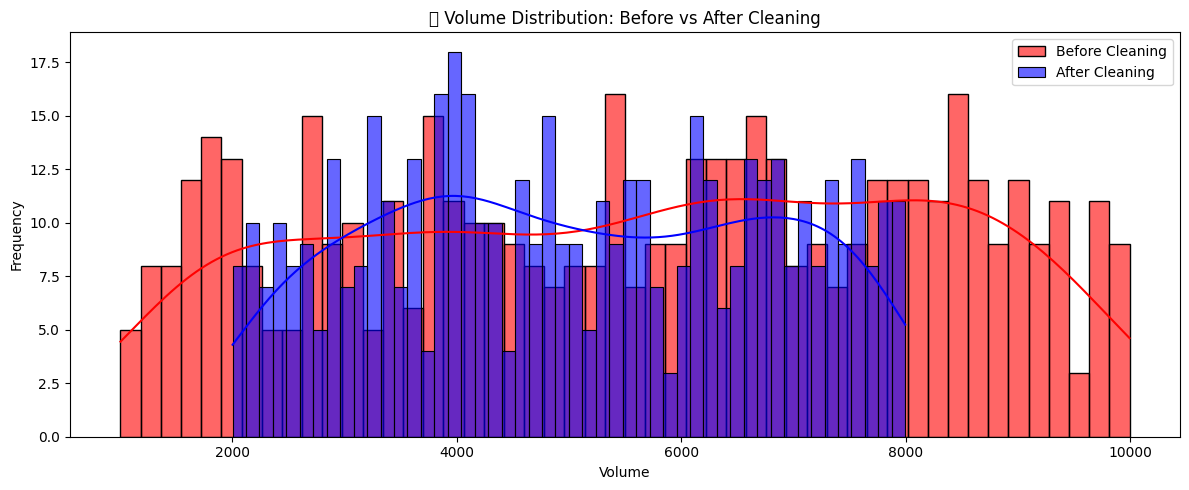

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate example data similar to your 'before' and 'after' cleaning
np.random.seed(42)
prices = pd.DataFrame({'volume': np.random.randint(1000, 10000, 500)})
merged_data = pd.DataFrame({'volume': np.random.randint(2000, 8000, 500)})

# Plot histogram comparison
plt.figure(figsize=(12, 5))
sns.histplot(prices['volume'], color='red', label='Before Cleaning', kde=True, bins=50, alpha=0.6)
sns.histplot(merged_data['volume'], color='blue', label='After Cleaning', kde=True, bins=50, alpha=0.6)

plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('📊 Volume Distribution: Before vs After Cleaning')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display

# If running in Colab and haven't uploaded your file yet, uncomment below to upload:
# from google.colab import files
# uploaded = files.upload()

# Step 0: Load your dataset (replace filename with your actual file)
df = pd.read_csv('cleaned_stock_data.csv')

# Step 1: Standardize 'close' and 'volume'
scaler = StandardScaler()
if {'close', 'volume'}.issubset(df.columns):
    df[['close', 'volume']] = scaler.fit_transform(df[['close', 'volume']])
else:
    raise KeyError("Missing 'close' or 'volume' columns in the DataFrame.")

# Step 2: One-hot encode 'sector' if present
if 'sector' in df.columns:
    df = pd.get_dummies(df, columns=['sector'], drop_first=True)

# Step 3: Split dataset
X = df.drop('close', axis=1)
y = df['close']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2)

# Step 4: Preview data
print("\n📌 Final feature preview (X_train):")
display(X_train.head())

print("\n📈 Target preview (y_train):")
display(y_train.head())



📌 Final feature preview (X_train):


,date,ticker,open,adj_close,low,high,volume,exchange,name,industry,...,sector_CONSUMER DURABLES,sector_CONSUMER NON-DURABLES,sector_CONSUMER SERVICES,sector_ENERGY,sector_FINANCE,sector_HEALTH CARE,sector_MISCELLANEOUS,sector_PUBLIC UTILITIES,sector_TECHNOLOGY,sector_TRANSPORTATION
5483083,2007-02-05,FBIZ,10.950000,7.283794,10.950000,10.950000,-0.093298,NASDAQ,"FIRST BUSINESS FINANCIAL SERVICES, INC.",MAJOR BANKS,...,False,False,False,False,True,False,False,False,False,False
4166410,2013-06-11,CCBG,10.860000,10.312247,10.800000,10.900000,-0.093321,NASDAQ,CAPITAL CITY BANK GROUP,MAJOR BANKS,...,False,False,False,False,True,False,False,False,False,False
18739536,2015-10-14,DB,29.010000,28.304810,28.760000,29.340000,0.056939,NYSE,DEUTSCHE BANK AG,MAJOR BANKS,...,False,False,False,False,True,False,False,False,False,False
18568542,1996-09-10,TSCO,1.421875,1.218142,1.390625,1.421875,0.008587,NASDAQ,TRACTOR SUPPLY COMPANY,RETAIL: BUILDING MATERIALS,...,False,False,True,False,False,False,False,False,False,False
13386731,2013-12-09,NSTG,13.400000,13.590000,13.400000,14.000000,-0.089004,NASDAQ,"NANOSTRING TECHNOLOGIES, INC.",BIOTECHNOLOGY: BIOLOGICAL PRODUCTS (NO DIAGNOS...,...,False,False,False,False,False,True,False,False,False,False



📈 Target preview (y_train):


,close
5483083,-0.579003
4166410,-0.587205
18739536,0.402546
18568542,-1.101732
13386731,-0.434641


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/Colab Notebooks/ Project 2: Data Cleaning and Preparation.ipynb" /content/
!ls /content

 drive	' Project 2: Data Cleaning and Preparation.ipynb'   sample_data


In [4]:

# STEP 1: Install Git
!apt-get install git -y

# STEP 2: Configure Git
!git config --global user.email "ndeeepu@gmail.com"
!git config --global user.name "ndeeepu"

# STEP 3: Clone your GitHub repository
!git clone https://github.com/ndeeepu/project-2-data-cleaning.git



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
fatal: destination path 'project-2-data-cleaning' already exists and is not an empty directory.


In [7]:
import os

# Show all files in current directory
for file in os.listdir():
    print(file)


.config
 Project 2: Data Cleaning and Preparation.ipynb
drive
project-2-data-cleaning
sample_data


In [8]:
import shutil

shutil.copy("Project 2: Data Cleaning and Preparation.ipynb", "/content/project-2-data-cleaning/")


FileNotFoundError: [Errno 2] No such file or directory: 'Project 2: Data Cleaning and Preparation.ipynb'